`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   

# Лабораторная работа №5. Работа с временным рядом

#### Данные отображают цены на акции компании BAC на момент их закрытия.

### Загрузка пакетов

In [1]:
import yfinance as yf

import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# оценка качества моделей
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

from sklearn. model_selection import train_test_split

# статистические методы
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# для быстрой обработки пропусков при расчете среднего
from pandas.core.nanops import nanmean as pd_nanmean

# для интерактивного отображения прогресса в расчетах
import tqdm
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Загрузка данных

In [2]:
data = yf.Ticker('BAC').history(interval = "5d", start
= '2012-01-01')
data.shape

(568, 7)

In [3]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-06 00:00:00-05:00,5.217461,5.293077,5.091436,5.192256,299630600,0.0,0.0
2012-01-11 00:00:00-05:00,5.545127,5.797179,5.477914,5.771974,354039600,0.0,0.0
2012-01-26 00:00:00-05:00,6.259274,6.301282,6.074436,6.133248,265938800,0.0,0.0
2012-01-31 00:00:00-05:00,6.024026,6.040829,5.923205,5.990419,212736300,0.0,0.0
2012-02-10 00:00:00-05:00,6.763377,6.822189,6.704565,6.780180,254420800,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-03 00:00:00-04:00,28.639999,28.980000,28.330000,28.590000,51996800,0.0,0.0
2023-04-13 00:00:00-04:00,28.559999,28.639999,28.240000,28.559999,52261400,0.0,0.0
2023-04-18 00:00:00-04:00,30.799999,30.930000,29.799999,30.559999,114498800,0.0,0.0


Нам нужны только данные о дате и цене закрытия (столбец 'Close').

In [4]:
data = data[['Close']]

In [5]:
data

,Close
Date,
2012-01-06 00:00:00-05:00,5.192256
2012-01-11 00:00:00-05:00,5.771974
2012-01-26 00:00:00-05:00,6.133248
2012-01-31 00:00:00-05:00,5.990419
2012-02-10 00:00:00-05:00,6.780180
...,...
2023-04-03 00:00:00-04:00,28.590000
2023-04-13 00:00:00-04:00,28.559999
2023-04-18 00:00:00-04:00,30.559999


### Построим график временного ряда

<Axes: title={'center': 'Цена на момент закрытия акции'}, xlabel='Date'>

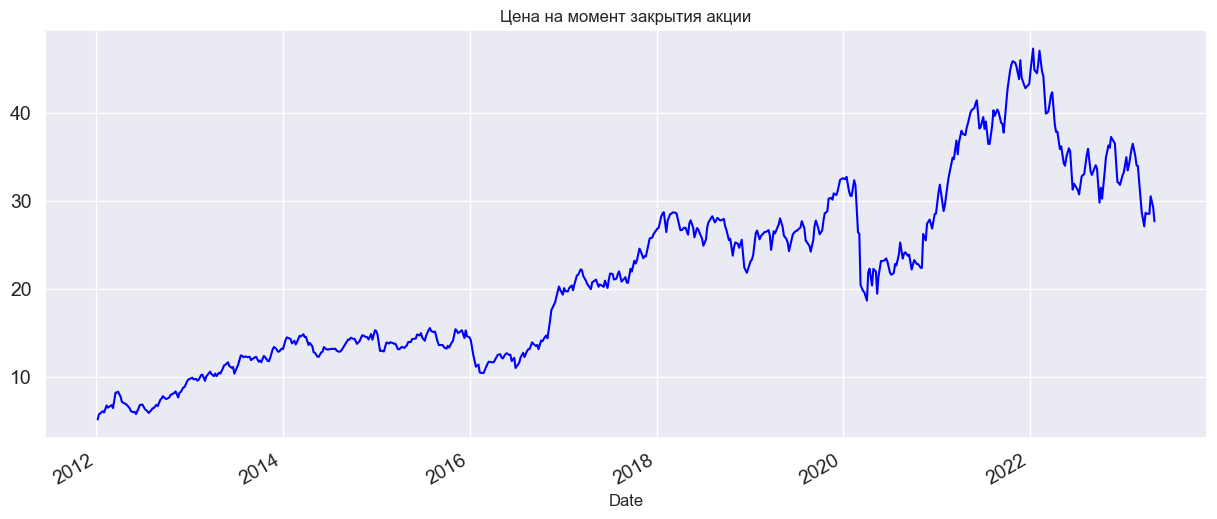

In [6]:
data.Close.plot( figsize=(15,6),title='Цена на момент закрытия акции', fontsize=14, color="blue")

График показывает, что цены на акции BAC были в основном стабильны в начале периода. Однако, существует большое количество короткосрочных колебаний цен, которые не подчиняются общему тренду и вызваны внешними факторами, такими как новости, экономические изменения и т.д.  

На графике цен на момент закрытия акций компании BAC, представленном выше, можно наблюдать общий тренд цен на протяжении всего периода. 

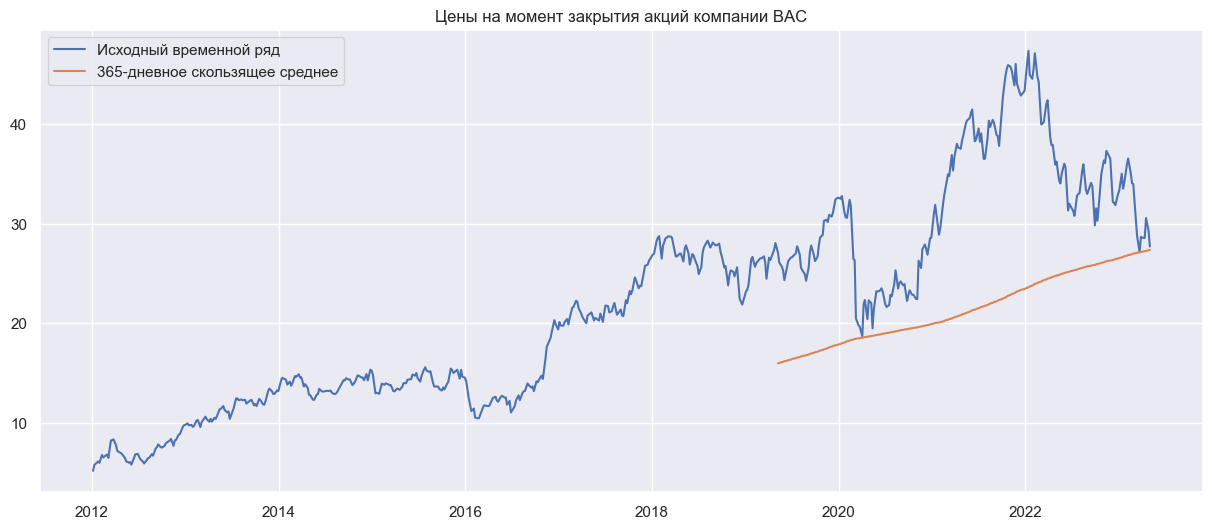

In [7]:
window = 365
rolling_mean = data.Close.rolling(window=window).mean()

plt.figure(figsize=(15,6))
plt.plot(data.Close, label='Исходный временной ряд')
plt.plot(rolling_mean, label='365-дневное скользящее среднее')
plt.legend(loc='best')
plt.title('Цены на момент закрытия акций компании BAC')
plt.show()

### Тест Дикки-Фуллера 

Проверим на уровне значимости 0.05

In [8]:
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    # p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [9]:
sample_data = data.Close

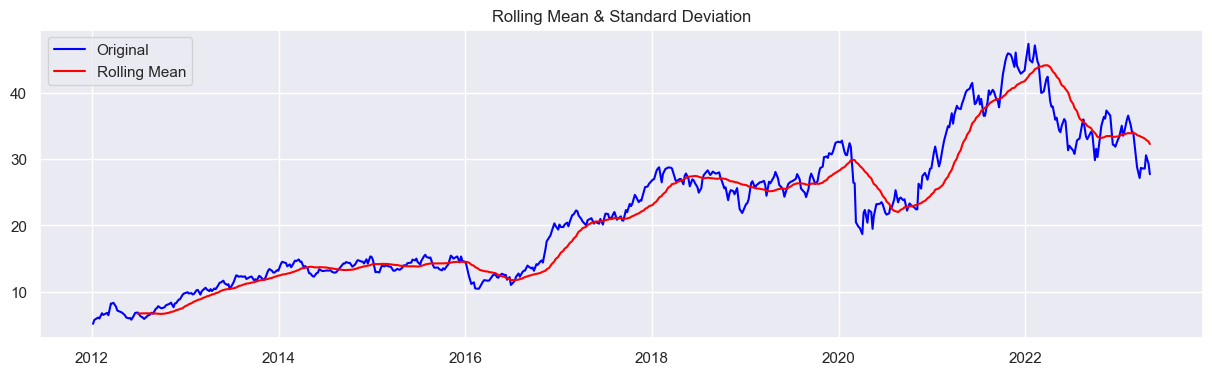

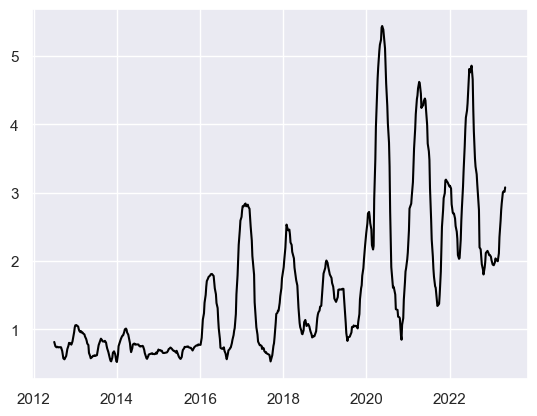

Results of Dickey-Fuller Test:
p-value = 0.4449. The series is likely non-stationary.
Test Statistic                  -1.673299
p-value                          0.444919
#Lags Used                       0.000000
Number of Observations Used    567.000000
Critical Value (1%)             -3.441936
Critical Value (5%)             -2.866651
Critical Value (10%)            -2.569492
dtype: float64


In [10]:
test_stationarity(sample_data)

На основании теста Dickey-Fuller, можно сделать вывод о том, что временной ряд не является стационарным. Это подтверждается значением p-value, превышающим уровень значимости 0.05, и недостаточным значением тестовой статистики для отклонения от нулевой гипотезы о нестационарности ряда.

### Методология Бокса-Дженкинса.

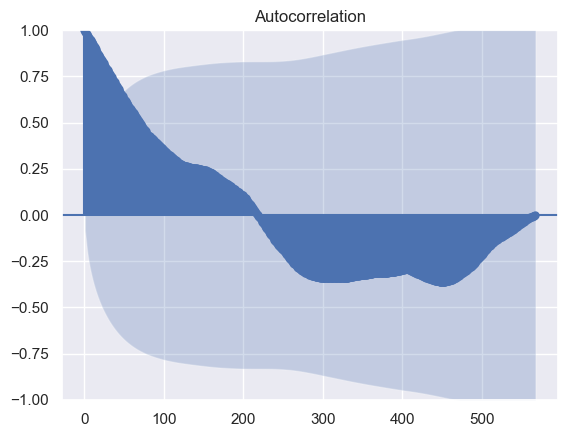

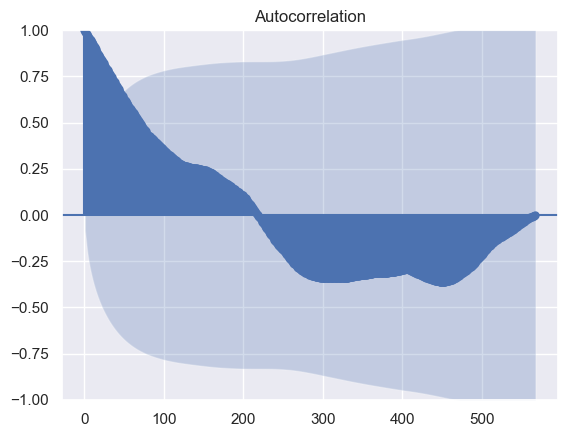

In [11]:
plot_acf(data.Close, lags=567)

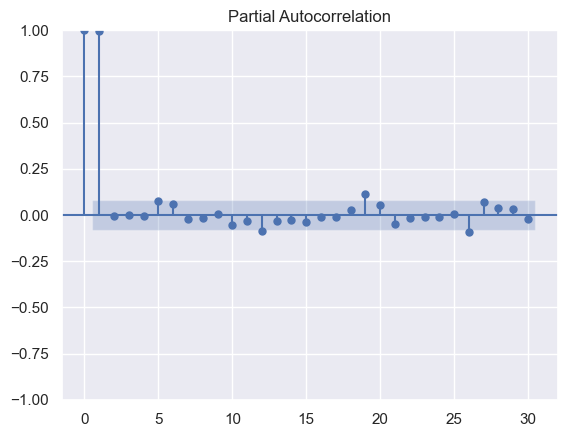

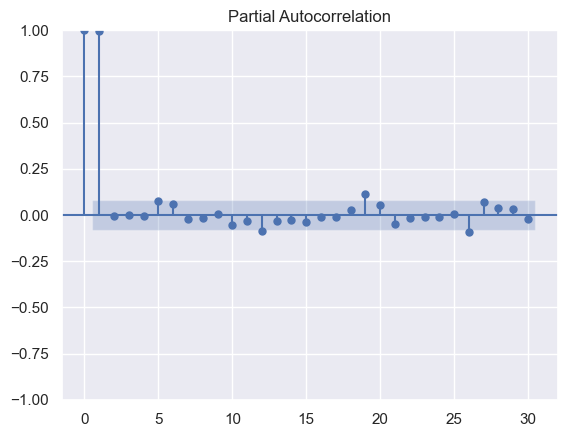

In [12]:
plot_pacf(data.Close, lags=30)

Это означает, что на 50-ом лаге автокорреляционная функция (ACF) последующие лаги становятся значимыми. Из графика PACF (Partial Autocorrelation Function) можно сделать вывод, что после второго лага все последующие лаги не являются значимыми, т.е. корреляция становится незначительной. 

Результаты построение PACF и ACF не удовлетворительны. Сложно определить примерные значения p,q для построения ARIMA-модели.
Предлагается для начала избавится от трендовой зависимости

### Удаления линейной трендовой составляющей из временного ряда

In [13]:
data["indexs"] = range(1, len(data)+1, 1)
from sklearn.linear_model import LinearRegression

X = np.array(data["indexs"]).reshape((-1, 1))
Y = np.array(data["Close"])

model = LinearRegression().fit(X,Y)
print('Y=', model.coef_[0], '*X +', model.intercept_)
print('coefficient of determination:', model.score(X, Y))
data["Close_t"] = data["Close"] - (data["indexs"] * model.coef_[0] + model.intercept_)
data

Y= 0.05718991054856846 *X + 5.489999845331923
coefficient of determination: 0.8364722846319814


,Close,indexs,Close_t
Date,,,
2012-01-06 00:00:00-05:00,5.192256,1,-0.354934
2012-01-11 00:00:00-05:00,5.771974,2,0.167594
2012-01-26 00:00:00-05:00,6.133248,3,0.471679
2012-01-31 00:00:00-05:00,5.990419,4,0.271659
2012-02-10 00:00:00-05:00,6.780180,5,1.004231
...,...,...,...
2023-04-03 00:00:00-04:00,28.590000,564,-9.155109
2023-04-13 00:00:00-04:00,28.559999,565,-9.242300
2023-04-18 00:00:00-04:00,30.559999,566,-7.299490


<Axes: title={'center': 'Цены на момент закрытия акций компании BAC без тренда'}, xlabel='Date'>

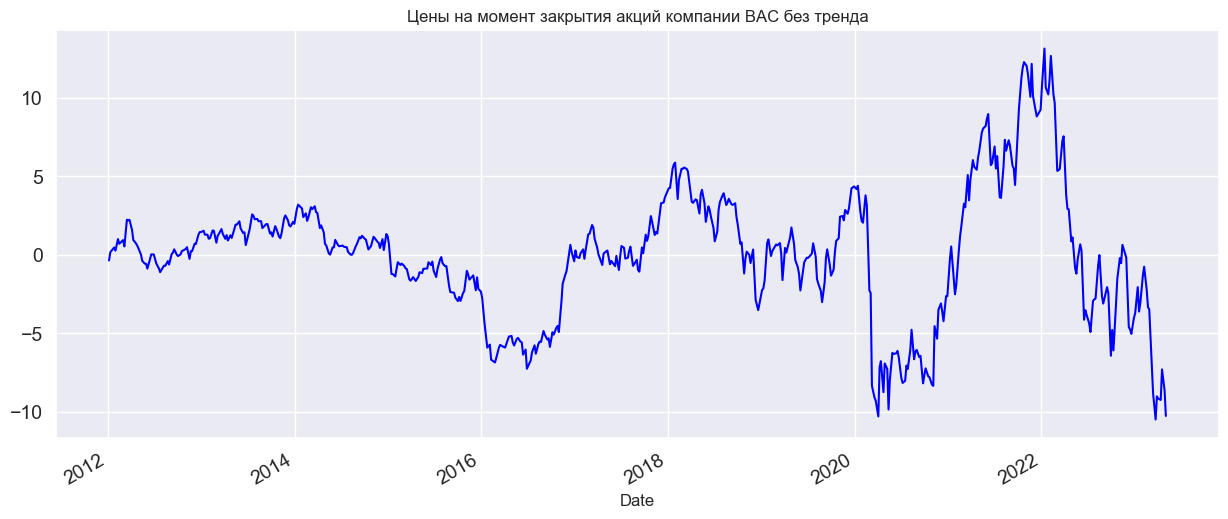

In [14]:
data.Close_t.plot( figsize=(15,6),title= 'Цены на момент закрытия акций компании BAC без тренда', fontsize=14, color="blue")

### Тест Дикки-Фуллера  без тренда

In [15]:
dftest_t = adfuller(data.Close_t,autolag='AIC')

if dftest_t[1] < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % dftest_t[1])
else:
    print('p-value = %.4f. The series is likely non-stationary.' % dftest_t[1])

p-value = 0.1247. The series is likely non-stationary.


Хоть ряд и не является стационарным, результаты теста Дики-Фуллера показывают, что значение p-value уменьшилось. Это может свидетельствовать о том, что ряд стал более стационарным, чем раньше. 

### Методология Бокса-Дженкинса без тренда

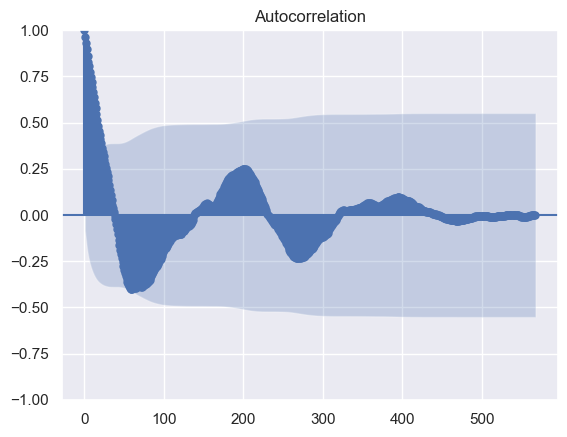

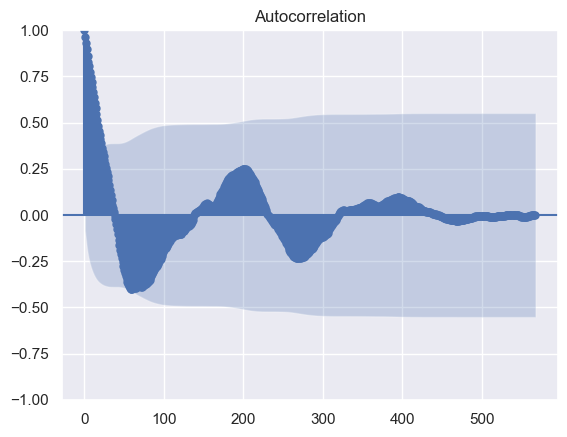

In [16]:
plot_acf(data.Close_t, lags=567)

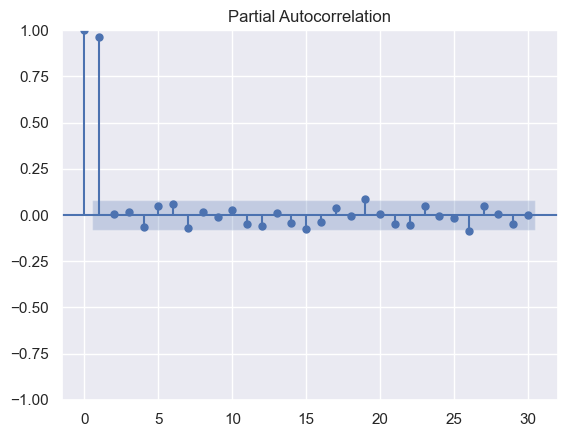

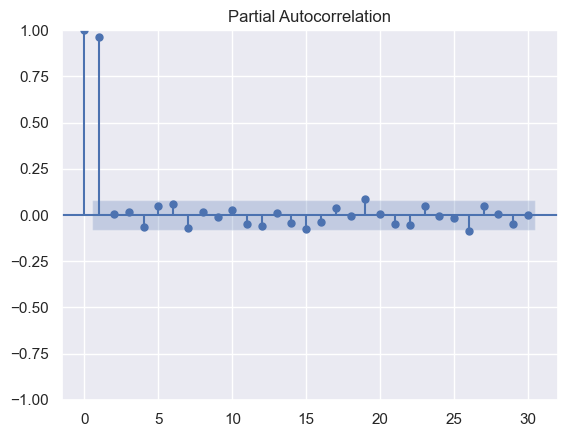

In [17]:
plot_pacf(data.Close_t, lags=30)

Зависимость цены акции от предыдущих значений снизилась, однако она все еще остается существенной.

### Разделяем на обучающую и тестовую выборки

In [18]:
# Разделение выборки на обучающую и тестовую
train, test = data[0:510], data[510:]
print(f"Размер обучающей выборки: {train.shape[0]}")
print(f"Размер тестовой выборки: {test.shape[0]}")

Размер обучающей выборки: 510
Размер тестовой выборки: 58


<Axes: title={'center': 'Цена на момент закрытия акции'}, xlabel='Date'>

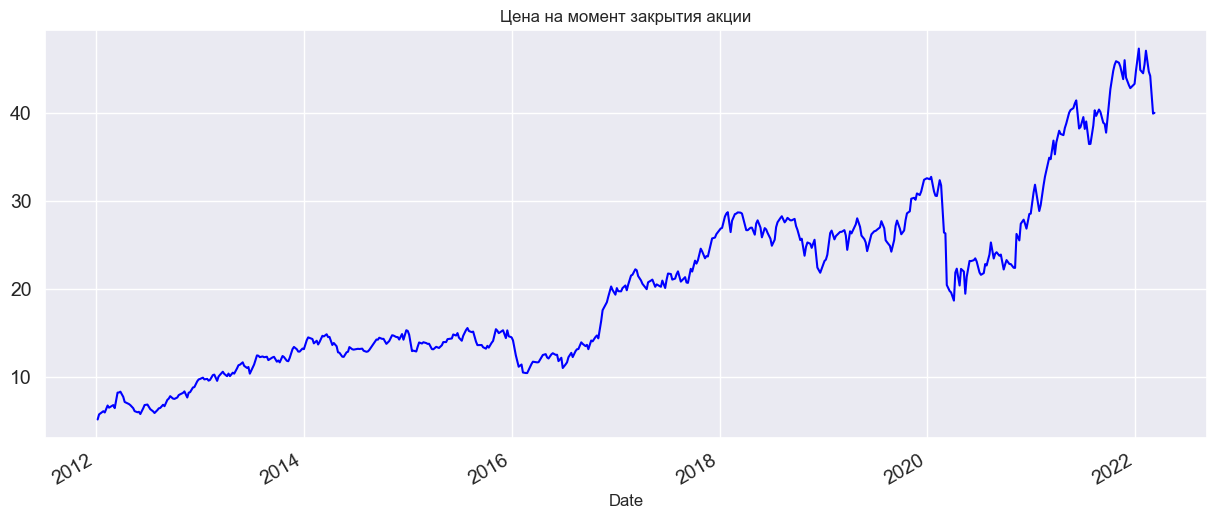

In [19]:
train.Close.plot( figsize=(15,6),title='Цена на момент закрытия акции', fontsize=14, color="blue")

In [23]:
import numpy as np
import itertools
import time
from datetime import timedelta
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

p = range(0, 8)
d = range(0, 3)
q = range(0, 15)
pdq = list(itertools.product(p, d, q))

def find_best_params(params):
    model_test = sm.tsa.arima.ARIMA(train.Close_t, order=params)
    result_test = model_test.fit()
    predictions = result_test.predict(start=len(train), end=len(train) + len(test) - 1)
    mae = mean_absolute_error(test.Close_t, predictions)
    return params, mae

best_params = (0, 0, 0)
best_MAE = np.inf

start_time = time.time()
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, mae = future.result()
        if mae < best_MAE:
            best_params = params
            best_MAE = mae
end_time = time.time()

total_time = end_time - start_time
average_time_per_iteration = total_time / len(pdq)

print("Best params:", best_params)
print("Best MAE:", best_MAE)
print("Total time:", str(timedelta(seconds=total_time)))
print("Average time per iteration:", str(timedelta(seconds=average_time_per_iteration)))

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [33:46<00:00,  5.63s/it]

Best params: (5, 0, 5)
Best MAE: 2.330168613934456
Total time: 0:33:47.226739
Average time per iteration: 0:00:05.631185


In [24]:
p = range(0, 8)
d = range(0, 3)
q = range(0, 15)
pdq = list(itertools.product(p, d, q))

def find_best_params(params):
    model_test = sm.tsa.arima.ARIMA(train.Close, order=params)
    result_test = model_test.fit()
    predictions = result_test.predict(start=0, end=len(train.Close) - 1)
    MAE = mean_absolute_error(train.Close, predictions)
    return params, MAE

best_params = (0, 0, 0)
best_MAE = np.inf

start_time = time.time()
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, MAE = future.result()
        if MAE < best_MAE:
            best_params = params
            best_MAE = MAE
end_time = time.time()

total_time = end_time - start_time
average_time_per_iteration = total_time / len(pdq)

print("Best params:", best_params)
print("Best MAE:", best_MAE)
print("Total time:", str(timedelta(seconds=total_time)))
print("Average time per iteration:", str(timedelta(seconds=average_time_per_iteration)))

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [33:48<00:00,  5.63s/it]

Best params: (6, 1, 14)
Best MAE: 0.6069839660677653
Total time: 0:33:48.753894
Average time per iteration: 0:00:05.635427


Исходя из полученных результатов, можно сделать вывод, что модель ARIMA(5,0,5), которая не учитывает тренд, даёт более точные прогнозы, чем модель ARIMA(6,1,14) учитывающая тренд.

### Проверим модель на тестовой выборке

In [26]:
test.Close

Date
2022-03-14 00:00:00-04:00    40.198658
2022-03-24 00:00:00-04:00    42.023209
2022-03-29 00:00:00-04:00    42.384212
2022-04-08 00:00:00-04:00    38.705845
2022-04-13 00:00:00-04:00    37.876503
2022-04-18 00:00:00-04:00    37.905773
2022-04-28 00:00:00-04:00    35.915356
2022-05-03 00:00:00-04:00    36.227577
2022-05-13 00:00:00-04:00    34.315216
2022-05-18 00:00:00-04:00    34.032261
2022-05-23 00:00:00-04:00    34.998199
2022-06-02 00:00:00-04:00    36.014275
2022-06-07 00:00:00-04:00    35.670811
2022-06-17 00:00:00-04:00    31.323584
2022-06-22 00:00:00-04:00    31.990879
2022-06-27 00:00:00-04:00    31.745548
2022-07-07 00:00:00-04:00    31.264708
2022-07-12 00:00:00-04:00    30.774050
2022-07-22 00:00:00-04:00    32.805374
2022-07-27 00:00:00-04:00    32.962383
2022-08-01 00:00:00-04:00    33.080143
2022-08-11 00:00:00-04:00    35.239033
2022-08-16 00:00:00-04:00    35.955391
2022-08-26 00:00:00-04:00    33.394157
2022-08-31 00:00:00-04:00    32.982010
2022-09-15 00:00:00-

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
model_test = sm.tsa.arima.ARIMA(test.Close, order = (7,2,8))
result_test = model_test.fit()
preds = result_test.predict(dynamic=False)

print(mean_absolute_percentage_error(test.Close, preds))

5.941438568937235


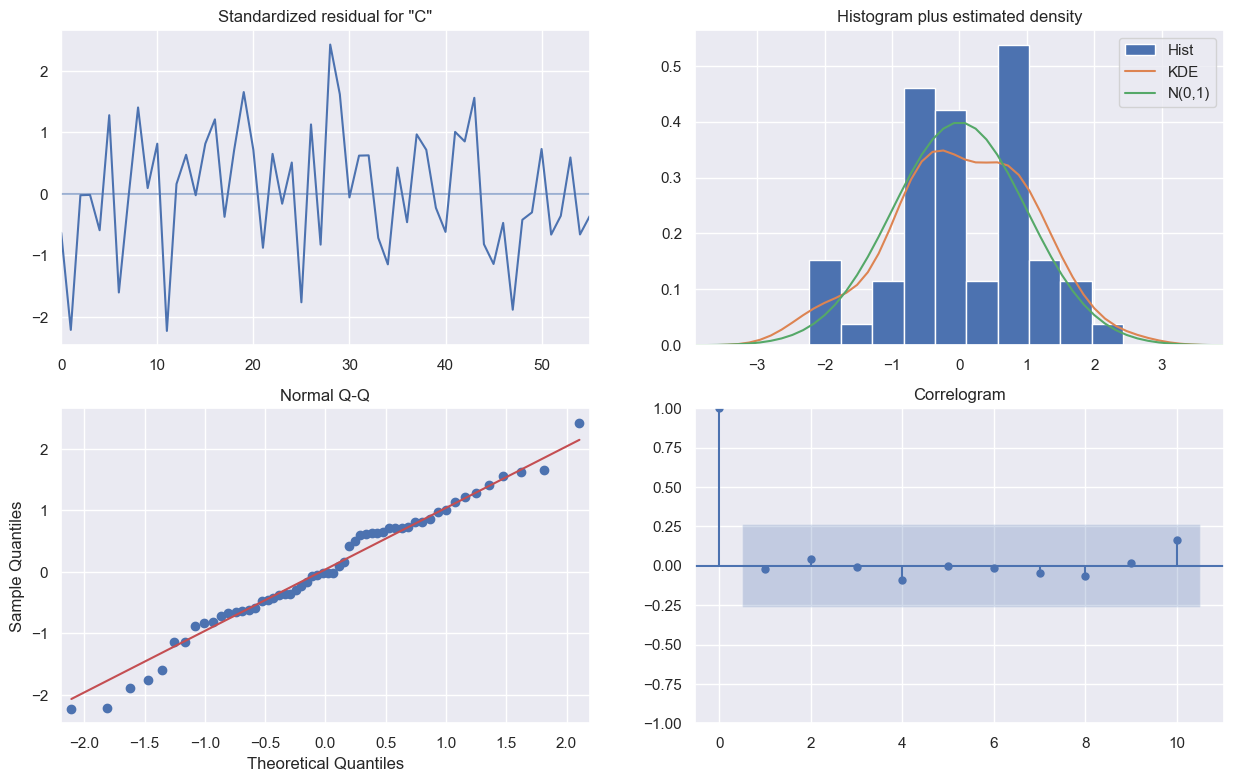

In [29]:
result_test.plot_diagnostics(figsize=(15, 9))
plt.show()

### Построим прогноз

In [30]:
# Получить прогноз на 10 шагов вперёд
pred_uc = result_test.get_forecast(steps=10)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

In [31]:
y = pd.Series(test.Close, index=test.index)
y

Date
2022-03-14 00:00:00-04:00    40.198658
2022-03-24 00:00:00-04:00    42.023209
2022-03-29 00:00:00-04:00    42.384212
2022-04-08 00:00:00-04:00    38.705845
2022-04-13 00:00:00-04:00    37.876503
2022-04-18 00:00:00-04:00    37.905773
2022-04-28 00:00:00-04:00    35.915356
2022-05-03 00:00:00-04:00    36.227577
2022-05-13 00:00:00-04:00    34.315216
2022-05-18 00:00:00-04:00    34.032261
2022-05-23 00:00:00-04:00    34.998199
2022-06-02 00:00:00-04:00    36.014275
2022-06-07 00:00:00-04:00    35.670811
2022-06-17 00:00:00-04:00    31.323584
2022-06-22 00:00:00-04:00    31.990879
2022-06-27 00:00:00-04:00    31.745548
2022-07-07 00:00:00-04:00    31.264708
2022-07-12 00:00:00-04:00    30.774050
2022-07-22 00:00:00-04:00    32.805374
2022-07-27 00:00:00-04:00    32.962383
2022-08-01 00:00:00-04:00    33.080143
2022-08-11 00:00:00-04:00    35.239033
2022-08-16 00:00:00-04:00    35.955391
2022-08-26 00:00:00-04:00    33.394157
2022-08-31 00:00:00-04:00    32.982010
2022-09-15 00:00:00-

In [40]:
dti = pd.date_range("2023-05-08 00:00:00-04:00", periods=10, freq="5D")
dti

DatetimeIndex(['2023-05-08 00:00:00-04:00', '2023-05-13 00:00:00-04:00',
               '2023-05-18 00:00:00-04:00', '2023-05-23 00:00:00-04:00',
               '2023-05-28 00:00:00-04:00', '2023-06-02 00:00:00-04:00',
               '2023-06-07 00:00:00-04:00', '2023-06-12 00:00:00-04:00',
               '2023-06-17 00:00:00-04:00', '2023-06-22 00:00:00-04:00'],
              dtype='datetime64[ns, UTC-04:00]', freq='5D')

In [41]:
y_pred_mean = pred_uc.predicted_mean
df = pd.DataFrame(y_pred_mean)
df = df.to_numpy()
print(df[:,0])
y_pred_mean_dti = pd.Series(data=df[:,0],index=dti)
y_pred_mean_dti.index.names = ['Date']
y_pred_mean_dti
type(y_pred_mean_dti)

[26.39056263 27.32519759 26.95205666 26.74401362 27.6666627  26.96742451
 26.72148628 26.08267319 26.28283748 25.64204033]


pandas.core.series.Series

In [42]:
y_pred = pred_ci.set_index(dti)
y_pred.index.names = ['Date']
y_pred
type(y_pred)

pandas.core.frame.DataFrame

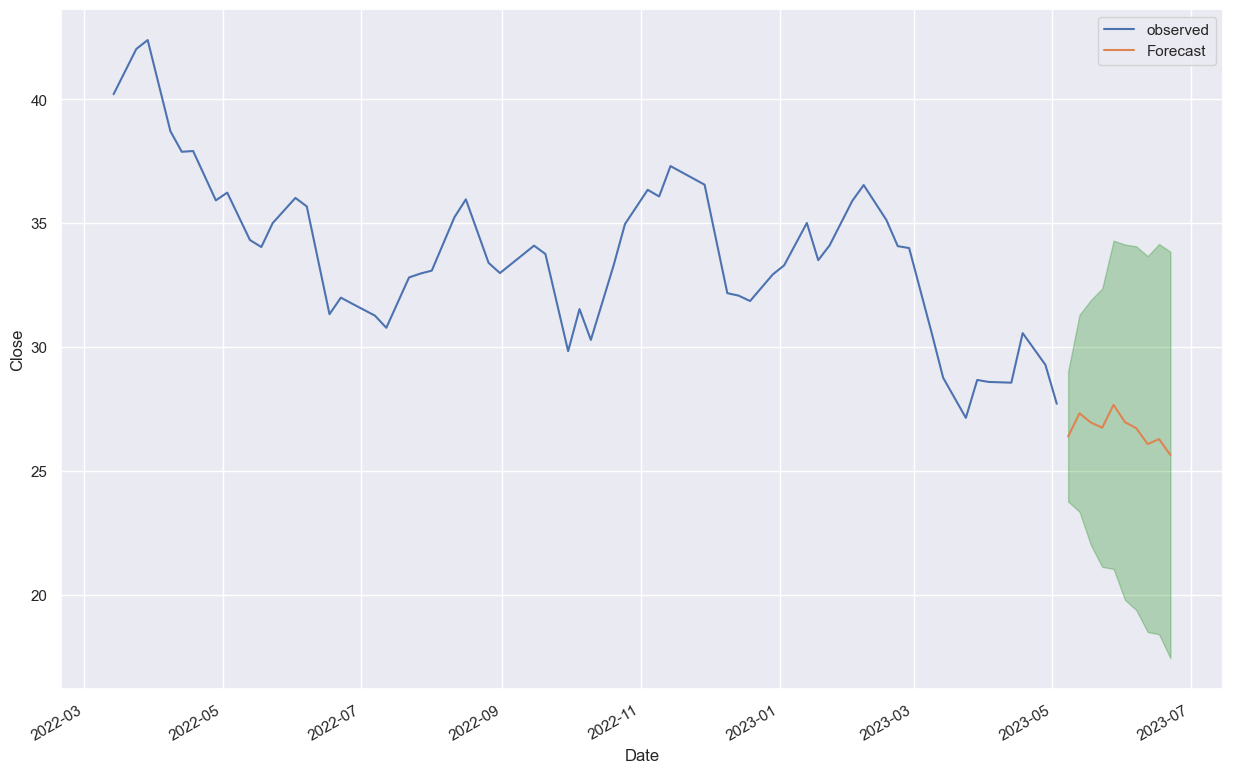

In [43]:
ax = y.plot(label='observed', figsize=(15, 10))
y_pred_mean_dti.plot(ax=ax, label='Forecast')
ax.fill_between(y_pred.index,
y_pred.iloc[:, 0],
y_pred.iloc[:, 1], color='green', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()

Исходя из анализа графика, можно сделать вывод, что в будущем цены на акции компании BAC скорее всего будут понижаться.

### Построение моделей для прогноза по разным периодам

In [35]:
data = yf.Ticker('BAC').history(interval = "5d", start
= '2012-01-01')
data.shape

(568, 7)

<Axes: title={'center': 'Цена закрытия акции'}, xlabel='Date'>

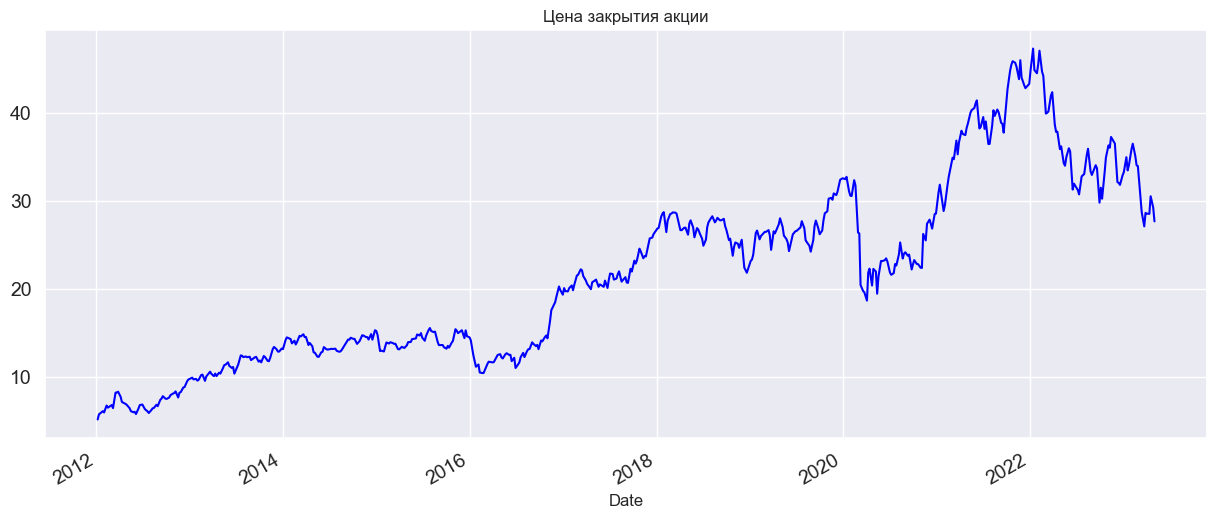

In [36]:
data.Close.plot( figsize=(15,6),title='Цена закрытия акции', fontsize=14, color="blue")

### Разделим исходные данные на 3 блока:

1) 2012.01.01 - 2015.10.14

2) 2015.10.14 - 2019.08.08

3) 2019.08.08 - н.в.

In [44]:
data_1 = data.index < '2015-10-14 00:00:00-04:00'
data_1 = data.loc[data_1]
data_1

,Close,indexs,Close_t
Date,,,
2012-01-06 00:00:00-05:00,5.192256,1,-0.354934
2012-01-11 00:00:00-05:00,5.771974,2,0.167594
2012-01-26 00:00:00-05:00,6.133248,3,0.471679
2012-01-31 00:00:00-05:00,5.990419,4,0.271659
2012-02-10 00:00:00-05:00,6.780180,5,1.004231
...,...,...,...
2015-09-17 00:00:00-04:00,13.654260,185,-2.415874
2015-09-22 00:00:00-04:00,13.404590,186,-2.722734
2015-10-02 00:00:00-04:00,13.241018,187,-2.943495


In [45]:
data_2 = data.query("index >= '2015-10-14 00:00:00-04:00' & index < '2019-08-08 00:00:00-04:00'")
data_2

,Close,indexs,Close_t
Date,,,
2015-10-22 00:00:00-04:00,13.912537,190,-2.443546
2015-10-27 00:00:00-04:00,14.119159,191,-2.294114
2015-11-06 00:00:00-05:00,15.453594,192,-1.016868
2015-11-11 00:00:00-05:00,15.281408,193,-1.246244
2015-11-16 00:00:00-05:00,15.005913,194,-1.578930
...,...,...,...
2019-07-08 00:00:00-04:00,26.766176,374,-0.112850
2019-07-18 00:00:00-04:00,27.022833,375,0.086617
2019-07-23 00:00:00-04:00,27.728653,376,0.735247


In [46]:
data_3 = data.query("index > '2019-08-08 00:00:00-04:00'")
data_3

,Close,indexs,Close_t
Date,,,
2019-08-12 00:00:00-04:00,25.336197,379,-1.828779
2019-08-22 00:00:00-04:00,24.923702,380,-2.298464
2019-08-27 00:00:00-04:00,24.263720,381,-3.015636
2019-09-06 00:00:00-04:00,25.586229,382,-1.750316
2019-09-11 00:00:00-04:00,27.182486,383,-0.211250
...,...,...,...
2023-04-03 00:00:00-04:00,28.590000,564,-9.155109
2023-04-13 00:00:00-04:00,28.559999,565,-9.242300
2023-04-18 00:00:00-04:00,30.559999,566,-7.299490


### Разделим выборку на тестовую и обучающую

In [47]:
train_1, test_1 = data_1[0:170], data_1[170:]
train_2, test_2 = data_2[0:170], data_2[170:]
train_3, test_3 = data_3[0:170], data_3[170:]

In [61]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

def find_best_params(params):
    try:
        model = sm.tsa.arima.ARIMA(train_1.Close, order=params)
        result = model.fit()
        predictions = result.predict()
        mae = mean_absolute_error(train_1.Close, predictions)
        return params, mae
    except:
        return params, np.inf

best_params = (0, 0, 0)
best_mae = np.inf

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, mae = future.result()
        if mae < best_mae:
            best_params = params
            best_mae = mae

model = sm.tsa.arima.ARIMA(test_1.Close, order=best_params)
result = model.fit()
predictions = result.predict()
mae_test = mean_absolute_error(test_1.Close, predictions)

print('Best model on 1 block:', best_params, 'MAE on train:', best_mae, 'MAE on test:', mae_test)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [08:18<00:00,  1.99s/it]


Best model on 1 block: (4, 0, 3) MAE on train: 0.3220683283837032 MAE on test: 0.27848834049088067


In [62]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

def find_best_params(params):
    try:
        model = sm.tsa.arima.ARIMA(train_2.Close, order=params)
        result = model.fit()
        predictions = result.predict()
        mae = mean_absolute_error(train_2.Close, predictions)
        return params, mae
    except:
        return params, np.inf

best_params = (0, 0, 0)
best_mae = np.inf

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, mae = future.result()
        if mae < best_mae:
            best_params = params
            best_mae = mae

model = sm.tsa.arima.ARIMA(test_2.Close, order=best_params)
result = model.fit()
test_predictions = result.predict()
test_mae = mean_absolute_error(test_2.Close, test_predictions)

print('Best model on 2 block:', best_params, 'MAE on train:', best_mae, 'MAE on test:', test_mae)

main()

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [08:26<00:00,  2.03s/it]


Best model on 2 block: (3, 0, 4) MAE on train: 0.5815833086125559 MAE on test: 0.49902263918671663


In [65]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))


def find_best_params(params):
    try:
        model = sm.tsa.arima.ARIMA(train_3.Close, order=params)
        result = model.fit()
        mae = np.mean(np.abs(result.resid))  # Calculate Mean Absolute Error
        return params, mae
    except:
        return params, np.inf

best_params = (0, 0, 0)
best_mae = np.inf

start_time = time.time()
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(find_best_params, params): params for params in pdq}
    for future in tqdm(as_completed(futures), total=len(pdq)):
        params, mae = future.result()
        if mae < best_mae:
            best_params = params
            best_mae = mae
end_time = time.time()

model = sm.tsa.arima.ARIMA(test_3.Close, order=best_params)
result = model.fit()
test_mae = np.mean(np.abs(result.resid))  # Calculate Mean Absolute Error for the test set

total_time = end_time - start_time
average_time_per_iteration = total_time / len(pdq)

print('Best model on 3 block:', best_params, 'MAE on train:', best_mae, 'MAE on test:', test_mae)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [08:58<00:00,  2.16s/it]


Best model on 3 block: (4, 0, 2) MAE on train: 1.1265244538112944 MAE on test: 1.109311816059373


Из результатов моделирования видно, что лучшая модель на первом блоке данных имеет порядок (4,0,3) и достигает MAE на тренировочной выборке в размере 0.322, а на тестовой - 0.278. Лучшая модель на втором блоке данных имеет порядок (3,0,4) и достигает MAE на тренировочной выборке в размере 0.582, а на тестовой - 0.499. Лучшая модель на третьем блоке данных имеет порядок (4,0,2) и достигает MAE на тренировочной выборке в размере 1.127, а на тестовой - 1.109.

Модель с наименьшим значением MAE на тестовой выборке является наиболее предпочтительной для прогнозирования будущих значений. Следовательно, на основе результатов моделирования можно сделать вывод, что наиболее точная модель на тестовой выборке была построена на первом блоке данных и имеет порядок (4,0,3).